In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from SALib.analyze import sobol

# to remove spines at the top and right
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
results = pd.read_csv('../data/concat_data.csv', index_col=0)
results['diff'] = results['newts_buffer'] - results['newts_corridor']

param_values = pd.read_csv('../data/parameter_new.csv', index_col=0)

problem = {
    'num_vars': 7,
    'names': [
        #'number-of-startind', # 15
        'capacity',  # 20
        'mean-juvenile-mortality-prob', # 0.5
        'mean-adult-mortality-prob', #0.2
        #'cropland-movement-cost', #5
        #'woodland-movement-cost', #1
        #'angle-for-viewing-ponds-and-woodland', #140
        'mortality-decrease-with-buffer', #0.1
        'distance-for-viewing-ponds-and-woodland', #2
        'movement-energy', #700
        'mean-number-of-female-offspring' #5
    ],
    'bounds': [
        #[5, 80],
        [10, 40],
        [0.3, 0.7],
        [0.1, 0.3],
        #[5, 7],
        #[1, 4],
        #[70, 180],
        [0.001, 0.2],
        [0.5, 3],
        [200, 1000],
        [4, 6]
    ]
}

results

,newts_buffer,newts_corridor,ponds_buffer,ponds_corridor,mean_newts_buffer,mean_ponds_buffer,mean_newts_corridor,mean_ponds_corridor,diff
0,36.0,0.0,6.0,0.0,31.363636,6.000000,5.818182,1.181818,36.0
1,93.0,26.0,7.0,5.0,102.727273,7.000000,33.363636,4.272727,67.0
2,6.0,0.0,2.0,0.0,13.000000,2.818182,3.636364,0.636364,6.0
3,12.0,0.0,3.0,0.0,15.363636,3.363636,3.636364,0.636364,12.0
4,33.0,3.0,6.0,2.0,35.909091,6.909091,14.818182,3.181818,30.0
...,...,...,...,...,...,...,...,...,...
251,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
252,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
253,0.0,0.0,0.0,0.0,0.000000,0.000000,3.636364,0.636364,0.0
254,11.0,0.0,3.0,0.0,11.272727,2.818182,3.636364,0.636364,11.0


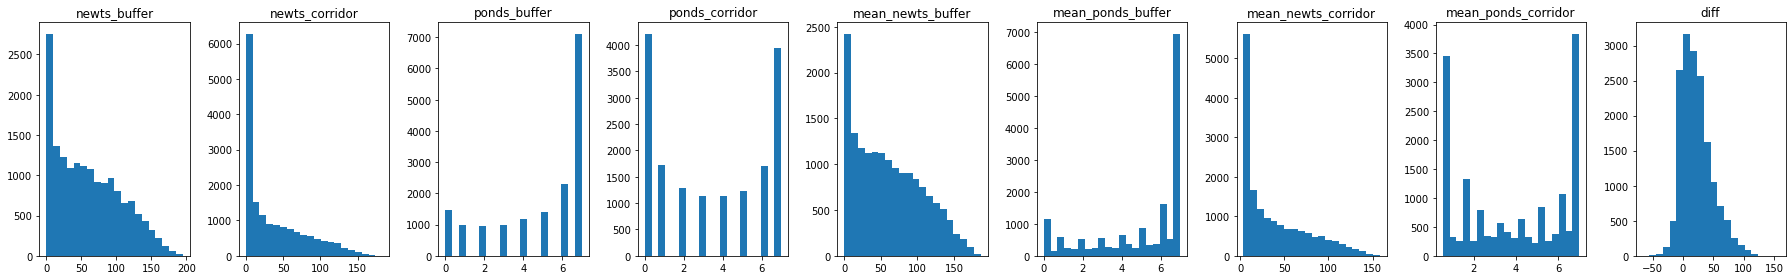

In [3]:
plt.figure(figsize=(25,4))
for i, output_name in enumerate(results.columns):
    plt.subplot(1, len(results.columns), i+1)
    plt.hist(results[output_name], 20)
    plt.title(output_name)

#plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('../results/output_hist.svg')

In [3]:
from SALib.analyze import hdmr

y = results['newts_buffer'].values
Si_buffer = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['newts_corridor'].values
Si_corridor = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['diff'].values
Si_diff = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

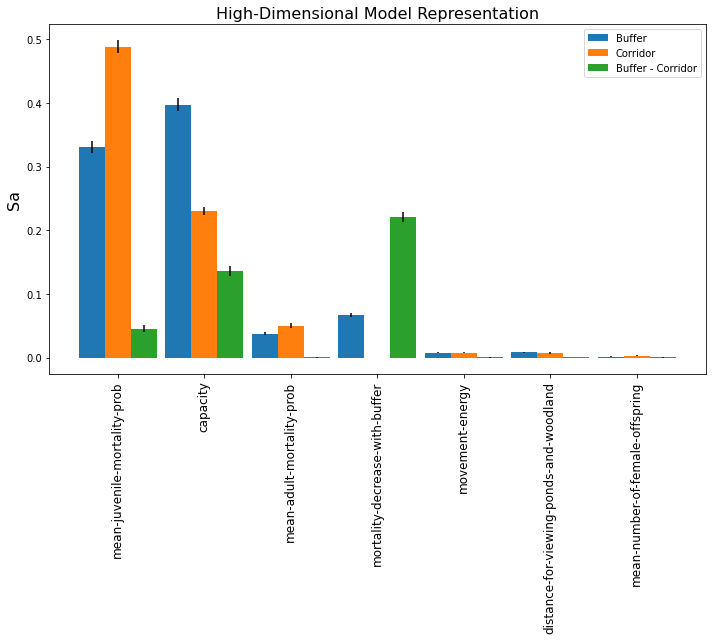

In [4]:
temp = np.array([Si_buffer['Sa'][0:7],
                 Si_corridor['Sa'][0:7]]).T

sorted_index = np.argsort(np.mean(temp, axis=1))[::-1]

order_no = 'Sa'
conf = f'{order_no}_conf'

plt.figure(figsize=(10,9))
plt.bar(np.arange(1,8)-0.3, Si_buffer[order_no][sorted_index][0:7], yerr=Si_buffer[conf][sorted_index][0:7], width=0.3, label='Buffer')
plt.bar(np.arange(1,8), Si_corridor[order_no][sorted_index][0:7], yerr=Si_corridor[conf][sorted_index][0:7], width=0.3, label='Corridor')
plt.bar(np.arange(1,8)+0.3, Si_diff[order_no][sorted_index][0:7], yerr=Si_diff[conf][sorted_index][0:7], width=0.3, label='Buffer - Corridor')
plt.xticks(np.arange(1,8), np.array(Si_buffer['Term'])[sorted_index][0:7], rotation=90, size=12)
plt.title('High-Dimensional Model Representation', size=16)
plt.ylabel(order_no, size=16)
plt.legend()
plt.tight_layout()
plt.savefig('../results/hdmr.svg');

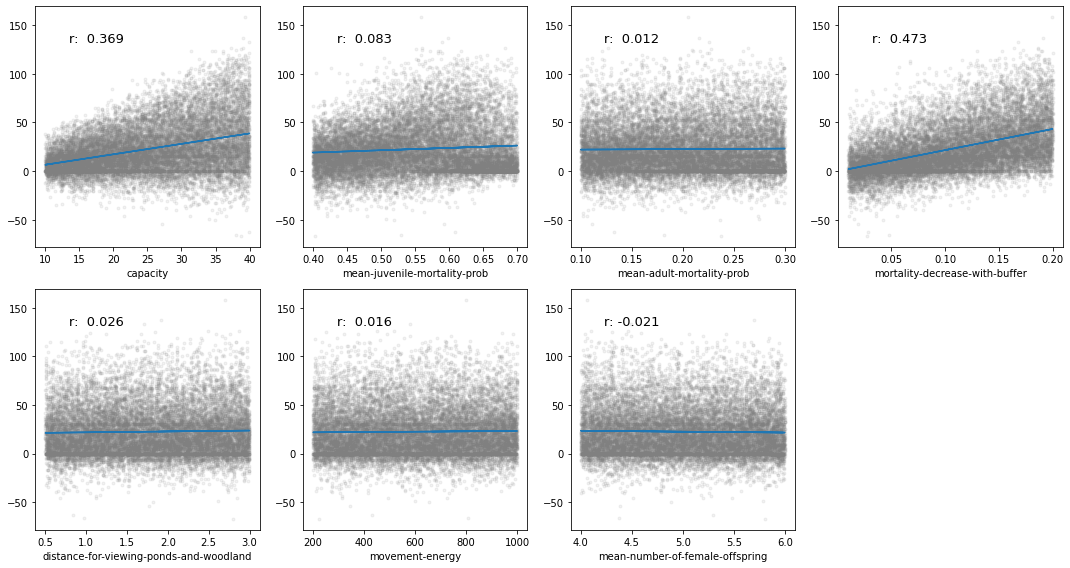

In [5]:
plt.figure(figsize=(15,8))

scenario = 'diff' # newts_corridor, newts_buffer

y = results[f'{scenario}']
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.xlabel(problem['names'][i])
    
    x = param_values.iloc[:,i]
    plt.plot(x,y, '.', alpha=0.1, color='gray')

    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x, poly1d_fn(x), '-')

    pearson = scipy.stats.pearsonr(x, y)
    plt.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    #print(pearson[1])
    
plt.tight_layout()
plt.savefig(f'../results/corr_{scenario}.png')

In [3]:
y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)

pd.DataFrame(Si_buffer['S2']) - pd.DataFrame(Si_buffer['S2_conf'])

,0,1,2,3,4,5,6
0,NaN,-0.07359,-0.070940,-0.081332,-0.084239,-0.093172,-0.093183
1,NaN,NaN,-0.060977,-0.039533,-0.040808,-0.032518,-0.043931
2,NaN,NaN,NaN,-0.017287,-0.007901,-0.008746,-0.020966
3,NaN,NaN,NaN,NaN,-0.009141,-0.024345,-0.028721
4,NaN,NaN,NaN,NaN,NaN,-0.017064,-0.021248
5,NaN,NaN,NaN,NaN,NaN,NaN,-0.031488
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
index_name, conf_name = 'S1', 'S1_conf' #'ST', 'ST_conf'

y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
buffer_df = pd.DataFrame({k:Si_buffer[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['newts_corridor'].values
Si_corridor = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
corridor_df = pd.DataFrame({k:Si_corridor[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['diff'].values
Si_diff = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
diff_df = pd.DataFrame({k:Si_diff[k] for k in [index_name,conf_name]},index=problem['names']) 

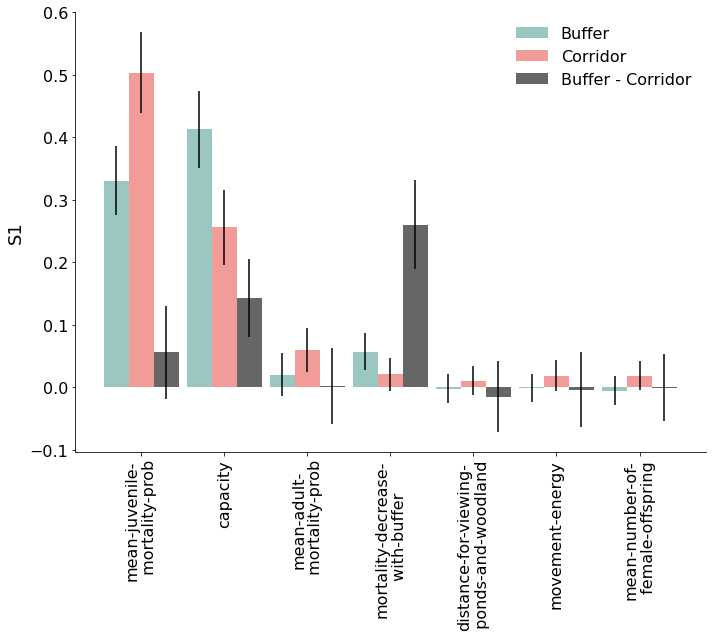

In [28]:

sorting_index = np.array([1,0,2,3,4,5,6])
labels = ['mean-juvenile-\n mortality-prob', 
          'capacity',
         'mean-adult-\n mortality-prob',
         'mortality-decrease-\n with-buffer',
         'distance-for-viewing-\n ponds-and-woodland',
         'movement-energy',
         'mean-number-of-\n female-offspring']

plt.figure(figsize=(10,9))

plt.bar(np.arange(1,8)-0.3, buffer_df[index_name][sorting_index], 
        yerr=buffer_df[conf_name][sorting_index], 
        width=0.3, color='#9AC7BF', label='Buffer')

plt.bar(np.arange(1,8), corridor_df[index_name][sorting_index], 
        yerr=corridor_df[conf_name][sorting_index], 
        width=0.3, color='#F19C99', label='Corridor')

plt.bar(np.arange(1,8)+0.3, diff_df[index_name][sorting_index], 
        yerr=diff_df[conf_name][sorting_index], 
        width=0.3, color='#666666', label='Buffer - Corridor')


plt.xticks(np.arange(1,8), labels, rotation=90, size=16)
plt.yticks(size=16)

#plt.title('Sobol index', size=16)
plt.ylabel(index_name, size=18)
plt.legend(prop={"size":16}, frameon=False)
plt.tight_layout()


plt.savefig('../results/sobol.png', dpi=400);

In [28]:
pd.DataFrame(Si_buffer['S2'], index=problem['names'], columns=problem['names']) - pd.DataFrame(Si_buffer['S2_conf'], index=problem['names'], columns=problem['names'])



,capacity,mean-juvenile-mortality-prob,mean-adult-mortality-prob,mortality-decrease-with-buffer,distance-for-viewing-ponds-and-woodland,movement-energy,mean-number-of-female-offspring
capacity,NaN,-0.07626,-0.083951,-0.086437,-0.087569,-0.089960,-0.090641
mean-juvenile-mortality-prob,NaN,NaN,-0.058812,-0.041133,-0.043702,-0.032804,-0.044101
mean-adult-mortality-prob,NaN,NaN,NaN,-0.017455,-0.006692,-0.006298,-0.017042
mortality-decrease-with-buffer,NaN,NaN,NaN,NaN,-0.011471,-0.021687,-0.028614
distance-for-viewing-ponds-and-woodland,NaN,NaN,NaN,NaN,NaN,-0.014271,-0.017826
movement-energy,NaN,NaN,NaN,NaN,NaN,NaN,-0.026043
mean-number-of-female-offspring,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Corridor:


,capacity,mean-juvenile-mortality-prob,mean-adult-mortality-prob,mortality-decrease-with-buffer,distance-for-viewing-ponds-and-woodland,movement-energy,mean-number-of-female-offspring
capacity,NaN,0.076247,0.000000,0.000000,0.000000,0.000000,0.000000
mean-juvenile-mortality-prob,NaN,NaN,0.036233,0.000000,0.000000,0.010192,0.000000
mean-adult-mortality-prob,NaN,NaN,NaN,0.012737,0.015797,0.000000,0.009712
mortality-decrease-with-buffer,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
distance-for-viewing-ponds-and-woodland,NaN,NaN,NaN,NaN,NaN,0.012589,0.018365
movement-energy,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
mean-number-of-female-offspring,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.0 0.07624675526532465


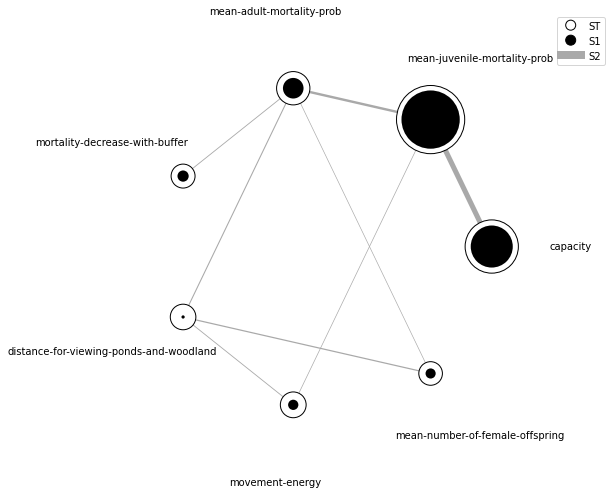

Buffer:


,capacity,mean-juvenile-mortality-prob,mean-adult-mortality-prob,mortality-decrease-with-buffer,distance-for-viewing-ponds-and-woodland,movement-energy,mean-number-of-female-offspring
capacity,NaN,0.020392,0.00432,0.002714,0.000000,0.000000,0.000000
mean-juvenile-mortality-prob,NaN,NaN,0.00551,0.022053,0.021515,0.032199,0.020403
mean-adult-mortality-prob,NaN,NaN,NaN,0.021287,0.033852,0.033082,0.021569
mortality-decrease-with-buffer,NaN,NaN,NaN,NaN,0.033226,0.019914,0.014539
distance-for-viewing-ponds-and-woodland,NaN,NaN,NaN,NaN,NaN,0.019033,0.015206
movement-energy,NaN,NaN,NaN,NaN,NaN,NaN,0.001748
mean-number-of-female-offspring,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0.0 0.03385211578704366


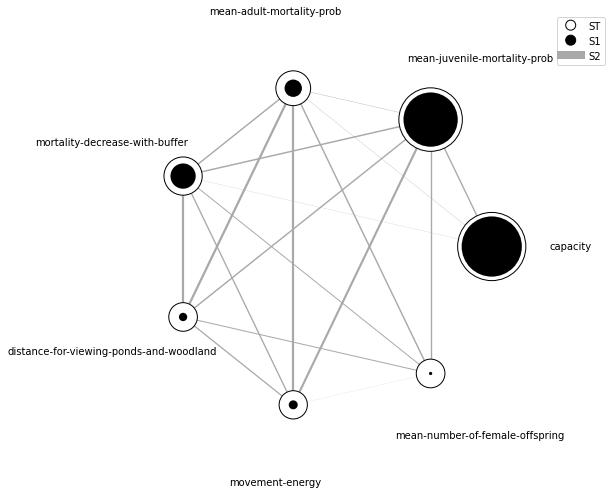

In [16]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 40 #25*1.8
    max_s_radius = 0.2

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    

    ax.set_xticks(locs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)
    
    display(s2)
    print(s2min, s2max)
    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0+max_linewidth_s2*normalize(weight, 0, 0.6) #s2min, s2max
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.9), borderaxespad=0.1,
              handler_map={plt.Circle: HandlerCircle()})


print('Corridor:')
fig = plot_sobol_indices(Si_corridor, criterion='ST', threshold=0.01)
fig.set_size_inches(12,7)
plt.tight_layout()
plt.savefig('../results/sobol_interaction_corridor.svg')
plt.show()

print('Buffer:')
fig = plot_sobol_indices(Si_buffer, criterion='ST', threshold=0.01)
fig.set_size_inches(12,7)
plt.tight_layout()
plt.savefig('../results/sobol_interaction_buffer.svg')
plt.show()